In [1]:
import pandas as vib
import torch
import csv
import numpy as np
import matplotlib.pyplot as plt
import h5py
import cv2 as cv
import os

dtype = torch.cuda.FloatTensor 
%matplotlib inline

torch.cuda.current_device()
print(torch.cuda.device(0))
print(torch.cuda.get_device_name(0))
def load_data(n_x,n_y,n):
    images=np.zeros((n, n_x,n_y))
    i=0
    
    for filenam in os.listdir("images"):
        images[i]=cv.imread("images/"+filenam,0)
        i=i+1
    
    return images
print(torch.cuda.is_available())

X=load_data(239,400,929)

        

/home/sanket/anaconda3/envs/cs231n/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


GeForce 940MX
True


In [2]:
Y=[]
with open('info.csv', 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    for (i, row) in enumerate(reader):
        x = row[' bumpPresent']
        Y.append(x)
Y=np.array(Y)
Y=Y.reshape((Y.shape[0],1))
# Y=np.squeeze(Y)

#Y= Y.astype(np.int)
y=[]
for i in Y:
    if i[0]==None:
        continue
    else:
        y.append(int(i[0]))

Y=np.array(y)
Y=Y.reshape((Y.shape[0],1))    
X= X[None, :, :]
X=X.transpose([1,0,2,3])
print(X.shape)    
X=torch.from_numpy(X)
Y=torch.from_numpy(Y)
X=X.cuda()
Y=Y.cuda()


(929, 1, 239, 400)


(1, 239, 400)

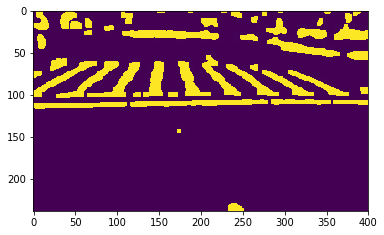

In [3]:
plt.imshow(np.array(X[709][0]))
np.array(X[0]).shape

In [4]:

class Flatten(torch.nn.Module):
    def forward(self, x):
        return x.view(x.size()[0], -1)
model = torch.nn.Sequential(
    torch.nn.Conv2d(1,32,3,stride=2,padding=0,bias=True),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(5, padding=0,  ceil_mode=False),
    torch.nn.Conv2d(32,64,3,stride=2,padding=0,bias=True),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(5, padding=0,  ceil_mode=False),
    Flatten(),
    torch.nn.Linear(6*64,2,bias=True),
    #torch.nn.Linear(10,2,bias=True),
    torch.nn.Softmax()
)
model.cuda()
model.double()
def weights_init(m):
    classname = m.__class__.__name__
    if (classname.find('Conv2d') != -1):
        torch.nn.init.xavier_normal(m.weight.data)
        torch.nn.init.constant(m.bias, 0)

        
#net = Net() # generate an instance network from the Net class
model.apply(weights_init) # apply weight init

#torch.nn.init.xavier_normal(model.state_dict()['weight'])
loss_fn= torch.nn.CrossEntropyLoss()
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for t in range(500):
    # Forward pass: compute predicted y by passing x to the model.
    a = np.zeros(X.shape[0], dtype=int)
    a[:50] = 1
    np.random.shuffle(a)
    
    X_batch=[np.array(X[z]) for z in range(X.shape[0]) if a[z]==1 ]
    X_batch=torch.from_numpy(np.array(X_batch))
    X_batch=X_batch.cuda()
    X_batch.double()
    Y_batch=np.zeros((50,2))
    Y_batch[:,1]=[np.array(Y[z]) for z in range(Y.shape[0]) if a[z]==1 ]
    Y_batch=torch.from_numpy(np.array(Y_batch))
    Y_batch=Y_batch.cuda()
    Y_batch=Y_batch.long()
    y_pred = model(X_batch)

    # Compute and print loss.
    loss = loss_fn(y_pred, torch.max(Y_batch, 1)[1])
    print(t, loss.item())

    
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()

/home/sanket/anaconda3/envs/cs231n/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
/home/sanket/anaconda3/envs/cs231n/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
/home/sanket/anaconda3/envs/cs231n/lib/python3.6/site-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0 0.7034316070796198


RuntimeError: cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1524584710464/work/aten/src/THC/generic/THCStorage.cu:58